# ML Trading System - Interactive Development Pipeline

This notebook walks through the entire ML trading pipeline step-by-step.

**Purpose**: Learn and experiment with each component during development phase.

**Steps**:
1. Data Ingestion (~5 min)
2. Feature Engineering (~2 min)
3. Model Training (~5 min)
4. Backtesting (~2 min)
5. Dashboard Population (~1 min)

---

## Setup & Imports

In [1]:
# Standard imports
import sys
import os
import yaml
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Working directory: {os.getcwd()}")
print(f"Project root: {project_root}")

Working directory: /home/bawbawz/Project/MLTrading_WSL/notebooks
Project root: /home/bawbawz/Project/MLTrading_WSL


In [2]:
# Load configuration
config_path = os.path.join(project_root, 'config/config.yaml')
with open(config_path) as f:
    config = yaml.safe_load(f)

print("✓ Configuration loaded")
print(f"  - Modeling algorithm: {config['modeling']['algorithm']}")
print(f"  - Portfolio top_k: {config['portfolio']['top_k']}")
print(f"  - Optimizer: {config['portfolio']['optimizer']}")

✓ Configuration loaded
  - Modeling algorithm: xgboost
  - Portfolio top_k: 20
  - Optimizer: pypfopt


---
## Step 1: Data Ingestion

Fetch OHLCV data for a subset of S&P 500 stocks.

**Tip**: Start with 20-30 stocks for quick testing, expand later.

In [3]:
from src.io.universe import load_sp500_constituents
from src.io.ingest_ohlcv import OHLCVIngester

# Load universe - START SMALL for testing
NUM_STOCKS = 30  # Adjust this: 20-30 for testing, 100+ for production
symbols = load_sp500_constituents()[:NUM_STOCKS]

print(f"Selected {len(symbols)} stocks for analysis")
print(f"Sample symbols: {symbols[:10]}")

2025-10-23 16:37:54.968 | WARNING  | src.io.universe:load_sp500_constituents:217 - Loaded 503 CURRENT S&P 500 symbols - WARNING: This creates SURVIVORSHIP BIAS! Consider using historical constituent data or broader universe.


Selected 30 stocks for analysis
Sample symbols: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [4]:
# Fetch OHLCV data from yfinance
ingester = OHLCVIngester()
start_date = config['ingest']['start_date']  # From config.yaml

print(f"Fetching data from {start_date} to present...")
print("This may take 2-5 minutes depending on number of stocks...\n")

data = ingester.fetch_ohlcv(symbols, start_date, None)

print(f"\n✓ Fetched data for {len(data)} symbols")
print(f"  Total rows: {sum(len(df) for df in data.values()):,}")

2025-10-23 16:37:54.975 | INFO     | src.io.ingest_ohlcv:__init__:31 - Initialized OHLCVIngester with provider=yfinance
2025-10-23 16:37:54.976 | INFO     | src.io.ingest_ohlcv:_fetch_yfinance:67 - Fetching 30 symbols from yfinance: 2015-01-01 to None


Fetching data from 2015-01-01 to present...
This may take 2-5 minutes depending on number of stocks...



Fetching OHLCV:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 11/30 [00:02<00:03,  5.24it/s]2025-10-23 16:37:57.877 | DEBUG    | src.io.ingest_ohlcv:_fetch_yfinance:103 - Fetched 1222 rows for ABNB
2025-10-23 16:37:57.989 | DEBUG    | src.io.ingest_ohlcv:_fetch_yfinance:103 - Fetched 2718 rows for AKAM
Fetching OHLCV: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.09it/s]
2025-10-23 


✓ Fetched data for 30 symbols
  Total rows: 80,044


In [5]:
# Save to parquet format
ingester.save_parquet(data)
print("✓ Data saved to data/parquet/")

# Explore the data
sample_symbol = symbols[0]
sample_df = data[sample_symbol]

print(f"\nSample data for {sample_symbol}:")
print(sample_df.head())
print(f"\nDate range: {sample_df['date'].min()} to {sample_df['date'].max()}")
print(f"Total trading days: {len(sample_df)}")

2025-10-23 16:38:00.878 | INFO     | src.io.ingest_ohlcv:save_parquet:128 - Saving 30 symbols to data/parquet/1d
Saving parquet: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 167.43it/s]
2025-10-23 16:38:01.061 | INFO     | src.io.ingest_ohlcv:save_parquet:147 - Saved data to data/parquet/1d


✓ Data saved to data/parquet/

Sample data for MMM:
                       date        open        high         low       close  \
0 2015-01-02 00:00:00-05:00  137.717392  138.026749  136.061874  137.173920   
1 2015-01-05 00:00:00-05:00  136.287628  136.822739  133.846161  134.080261   
2 2015-01-06 00:00:00-05:00  134.464890  134.924744  131.889633  132.650497   
3 2015-01-07 00:00:00-05:00  133.695648  134.013382  132.892975  133.612045   
4 2015-01-08 00:00:00-05:00  134.322739  136.864548  134.214050  136.814377   

   Adj Close   volume  dividends  splits symbol  
0  96.521545  2531214        0.0     0.0    MMM  
1  94.344673  4416708        0.0     0.0    MMM  
2  93.338669  4224272        0.0     0.0    MMM  
3  94.015236  3685235        0.0     0.0    MMM  
4  96.268547  3758908        0.0     0.0    MMM  

Date range: 2015-01-02 00:00:00-05:00 to 2025-10-22 00:00:00-04:00
Total trading days: 2718


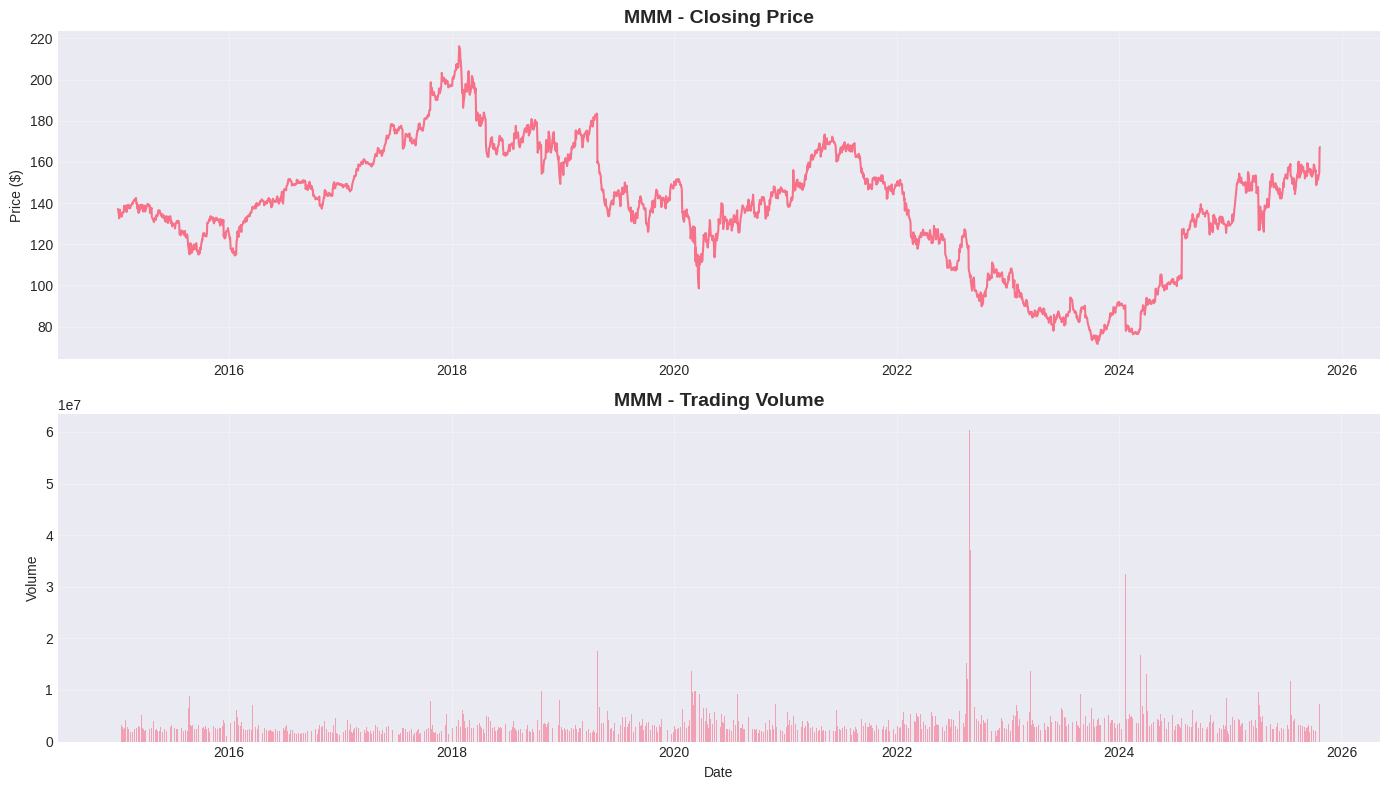

In [6]:
# Visualize sample stock price
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price chart
axes[0].plot(sample_df['date'], sample_df['close'], linewidth=1.5)
axes[0].set_title(f"{sample_symbol} - Closing Price", fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Volume chart
axes[1].bar(sample_df['date'], sample_df['volume'], alpha=0.6)
axes[1].set_title(f"{sample_symbol} - Trading Volume", fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
from src.io.ingest_fundamentals import FundamentalsIngester

# Initialize fundamental data ingester
fund_ingester = FundamentalsIngester(storage_path="data/fundamentals")

print(f"Fetching fundamental data for {len(symbols)} symbols...")
print("This may take 2-3 minutes...\n")

# Fetch fundamental data
fundamental_data = fund_ingester.fetch_fundamentals(symbols)

print(f"\n✓ Fetched fundamental data for {len(fundamental_data)} symbols")

# Save to parquet
fund_ingester.save_parquet(fundamental_data)
print("✓ Fundamental data saved to data/fundamentals/")

# Preview sample data
if len(fundamental_data) > 0:
    sample_symbol = list(fundamental_data.keys())[0]
    sample_fund = fundamental_data[sample_symbol]
    print(f"\nSample fundamental data for {sample_symbol}:")
    print(sample_fund.head())
    print(f"\nColumns: {list(sample_fund.columns)}")
    print(f"Date range: {sample_fund['date'].min()} to {sample_fund['date'].max()}")

2025-10-23 16:38:02.952 | INFO     | src.io.ingest_fundamentals:__init__:25 - Initialized FundamentalsIngester with storage_path=data/fundamentals
2025-10-23 16:38:02.952 | INFO     | src.io.ingest_fundamentals:fetch_fundamentals:52 - Fetching fundamentals for 30 symbols


Fetching fundamental data for 30 symbols...
This may take 2-3 minutes...



Fetching fundamentals: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]
2025-10-23 16:38:24.263 | INFO     | src.io.ingest_fundamentals:fetch_fundamentals:63 - Successfully fetched 30/30 symbols
2025-10-23 16:38:24.265 | INFO     | src.io.ingest_fundamentals:save_parquet:178 - Saving 30 symbols to data/fundamentals



✓ Fetched fundamental data for 30 symbols


Saving fundamentals: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 367.37it/s]
2025-10-23 16:38:24.350 | INFO     | src.io.ingest_fundamentals:save_parquet:187 - Saved fundamental data to data/fundamentals


✓ Fundamental data saved to data/fundamentals/

Sample fundamental data for MMM:
  symbol       date period_type   market_cap   pe_ratio   pb_ratio  ps_ratio  \
5    MMM 2024-03-31   quarterly  88836767744  26.671452  19.195362   3.57852   
4    MMM 2024-06-30   quarterly  88836767744  26.671452  19.195362   3.57852   
3    MMM 2024-09-30   quarterly  88836767744  26.671452  19.195362   3.57852   
2    MMM 2024-12-31   quarterly  88836767744  26.671452  19.195362   3.57852   
1    MMM 2025-03-31   quarterly  88836767744  26.671452  19.195362   3.57852   

   ev_ebitda      roe      roa  current_ratio  quick_ratio  debt_to_equity  \
5     15.724  0.72921  0.07971          1.842        1.027         281.904   
4     15.724  0.72921  0.07971          1.842        1.027         281.904   
3     15.724  0.72921  0.07971          1.842        1.027         281.904   
2     15.724  0.72921  0.07971          1.842        1.027         281.904   
1     15.724  0.72921  0.07971          1.842   

### Step 1.5: Fetch Fundamental Data

Now let's fetch fundamental data (income statements, balance sheets, cash flow statements) for the same symbols.

---
## Step 2: Feature Engineering

Generate technical indicators and forward return labels.

In [8]:
from src.features.ta_features import create_technical_features
from src.labeling.labels import generate_forward_returns

# Load saved parquet data
df = ingester.load_parquet(symbols)

print(f"Loaded {len(df):,} rows of OHLCV data")
print(f"Columns: {list(df.columns)}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique symbols: {df['symbol'].nunique()}")

2025-10-23 16:38:24.371 | INFO     | src.io.ingest_ohlcv:load_parquet:185 - Loading 30 symbols from data/parquet/1d
Loading parquet: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 423.07it/s]
2025-10-23 16:38:24.453 | INFO     | src.io.ingest_ohlcv:load_parquet:207 - Loaded 80044 rows from 30 symbols


Loaded 80,044 rows of OHLCV data
Columns: ['date', 'open', 'high', 'low', 'close', 'Adj Close', 'volume', 'dividends', 'splits', 'symbol']

Date range: 2015-01-02 00:00:00-05:00 to 2025-10-22 00:00:00-04:00
Unique symbols: 30


### Step 2.5: Add Fundamental Features with PIT Alignment

Now let's integrate fundamental features using Point-in-Time (PIT) alignment to prevent look-ahead bias.

In [24]:
# Reload the module to get latest fixes
import importlib
import sys
if 'src.features.fa_features' in sys.modules:
    importlib.reload(sys.modules['src.features.fa_features'])
    print("✓ Reloaded fa_features module")

from src.features.fa_features import FundamentalFeatures

print("Loading fundamental data...")
# Load all saved fundamental data
fundamentals_df = fund_ingester.load_parquet(symbols)

if fundamentals_df.empty:
    print("⚠️ No fundamental data found. Run Step 1.5 first.")
else:
    print(f"✓ Loaded {len(fundamentals_df)} fundamental records")
    print(f"  Symbols: {fundamentals_df['symbol'].nunique()}")
    print(f"  Date range: {fundamentals_df['date'].min()} to {fundamentals_df['date'].max()}")
    
    # Initialize fundamental features with PIT alignment
    fa_features = FundamentalFeatures(config)
    
    print("\nComputing fundamental features with PIT alignment...")
    print(f"  PIT constraints:")
    print(f"    - Min lag: {fa_features.pit_min_lag_days} days")
    print(f"    - Default publication lag: {fa_features.default_public_lag_days} days")
    print(f"    - Earnings blackout: {fa_features.earnings_blackout_days} days")
    
    # Store original column count
    original_cols = len(df.columns)
    
    # Compute and align fundamental features
    df = fa_features.compute_features(df, fundamentals_df)
    
    new_cols = len(df.columns) - original_cols
    print(f"\n✓ Fundamental features added: {new_cols} new columns")
    
    # Show new fundamental feature columns
    fund_feature_cols = [col for col in df.columns if any(x in col for x in ['ratio', 'roe', 'roa', 'debt', 'margin', 'qoq', 'quality', 'equity', 'revenue', 'income', 'cash_flow'])]
    print(f"\nSample fundamental features:")
    for col in fund_feature_cols[:15]:
        print(f"  - {col}")
    if len(fund_feature_cols) > 15:
        print(f"  ... and {len(fund_feature_cols) - 15} more")

2025-10-23 16:41:07.485 | INFO     | src.io.ingest_fundamentals:load_parquet:220 - Loading 30 symbols from data/fundamentals


✓ Reloaded fa_features module
Loading fundamental data...


Loading fundamentals: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 429.62it/s]
/home/bawbawz/Project/MLTrading_WSL/src/io/ingest_fundamentals.py:241: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(dfs, ignore_index=True)
2025-10-23 16:41:07.566 | INFO     | src.io.ingest_fundamentals:load_parquet:242 - Loaded 174 rows from 30 symbols
2025-10-23 16:41:07.570 | INFO     | src.features.fa_features:__init__:29 - Initiali

✓ Loaded 174 fundamental records
  Symbols: 30
  Date range: 2024-02-29 00:00:00 to 2025-08-31 00:00:00

Computing fundamental features with PIT alignment...
  PIT constraints:
    - Min lag: 1 days
    - Default publication lag: 45 days
    - Earnings blackout: 2 days


2025-10-23 16:41:07.699 | DEBUG    | src.features.fa_features:_align_pit_fundamentals:121 - Stripped timezone from price_df['date'] for merge compatibility


ValueError: left keys must be sorted

In [ ]:
# Generate technical features
print("Generating technical features...")
df = create_technical_features(df, config)

print(f"\n✓ Technical features created")
print(f"  Total columns now: {len(df.columns)}")

# Show feature columns
feature_cols = [col for col in df.columns if col not in ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'adj_close']]
print(f"\nGenerated features ({len(feature_cols)}):")
for col in feature_cols[:10]:
    print(f"  - {col}")
if len(feature_cols) > 10:
    print(f"  ... and {len(feature_cols) - 10} more")

In [14]:
# Generate forward return labels
print("Generating forward return labels...")
df = generate_forward_returns(df, config)

label_col = f"forward_return_{config['labels']['horizon']}d"
print(f"\n✓ Labels created: {label_col}")
print(f"\nLabel statistics:")
print(df[label_col].describe())

2025-10-23 16:39:23.411 | INFO     | src.labeling.labels:__init__:27 - Initialized LabelGenerator: horizon=5, type=return
2025-10-23 16:39:23.412 | INFO     | src.labeling.labels:generate_labels:39 - Generating labels for 80044 rows
/home/bawbawz/Project/MLTrading_WSL/src/labeling/labels.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('symbol', group_keys=False).apply(self._generate_symbol_labels)
2025-10-23 16:39:23.597 | INFO     | src.labeling.labels:generate_labels:46 - Generated labels: 80044 rows


Generating forward return labels...

✓ Labels created: forward_return_5d

Label statistics:
count    79894.000000
mean         0.002758
std          0.041920
min         -0.420907
25%         -0.016927
50%          0.003400
75%          0.023164
max          0.477778
Name: forward_return_5d, dtype: float64


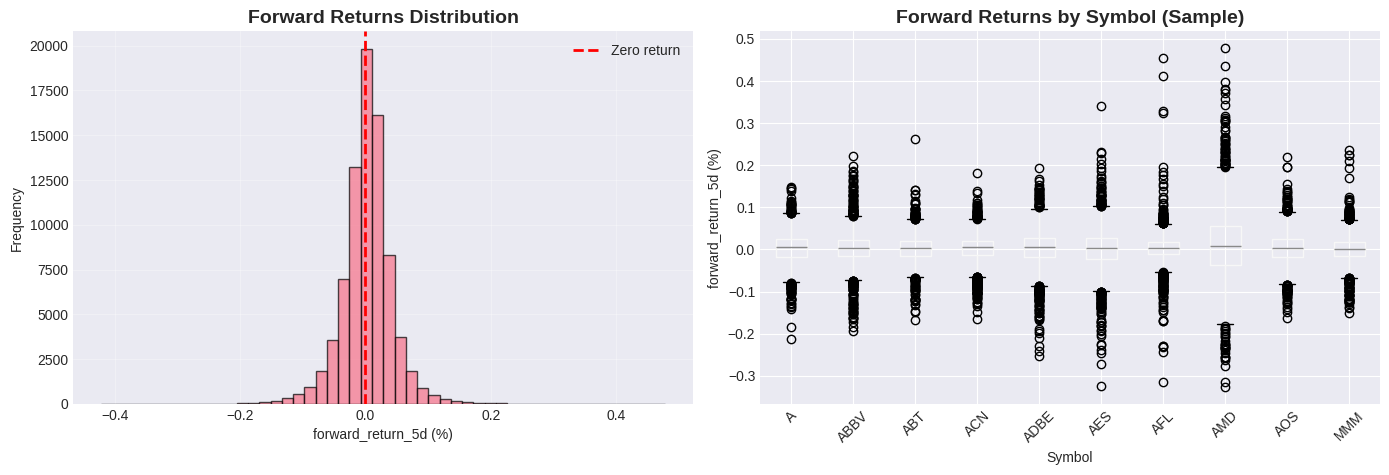

In [15]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df[label_col].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Forward Returns Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'{label_col} (%)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by symbol (sample)
sample_symbols = symbols[:10]
sample_data = df[df['symbol'].isin(sample_symbols)]
sample_data.boxplot(column=label_col, by='symbol', ax=axes[1], rot=45)
axes[1].set_title('Forward Returns by Symbol (Sample)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel(f'{label_col} (%)')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [16]:
# Save features
from src.io.storage import save_dataframe

save_dataframe(df, 'data/features/all_features.parquet')
print("✓ Features saved to data/features/all_features.parquet")

# Check for missing values
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(f"\nMissing values (top 10 columns with most nulls):")
print(missing_pct.head(10))

2025-10-23 16:39:31.583 | DEBUG    | src.io.storage:save_dataframe:37 - Saved 80044 rows to data/features/all_features.parquet


✓ Features saved to data/features/all_features.parquet

Missing values (top 10 columns with most nulls):
sma_200d               7.458398
dist_sma_200d          7.458398
momentum_100d          3.747939
log_momentum_100d      3.747939
dist_sma_100d          3.710459
sma_100d               3.710459
return_autocorr_60d    2.276248
return_zscore_60d      2.273749
return_skew_60d        2.248763
return_kurt_60d        2.248763
dtype: float64


In [ ]:
# Visualize fundamental features distribution
try:
    fundamentals_df
    fund_feature_cols
    can_visualize = not fundamentals_df.empty and len(fund_feature_cols) > 0
except NameError:
    can_visualize = False
    print("ℹ️ No fundamental features to visualize")

if can_visualize:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Select key fundamental features
    viz_features = []
    for feat in ['pe_ratio_calc', 'roe_calc', 'debt_to_equity_calc', 'profit_margin']:
        if feat in df.columns:
            viz_features.append(feat)
    
    if len(viz_features) >= 4:
        for idx, feat in enumerate(viz_features[:4]):
            row = idx // 2
            col = idx % 2
            
            data = df[feat].dropna()
            if len(data) > 0:
                axes[row, col].hist(data, bins=50, alpha=0.7, edgecolor='black')
                axes[row, col].set_title(f'{feat} Distribution', fontsize=12, fontweight='bold')
                axes[row, col].set_xlabel(feat)
                axes[row, col].set_ylabel('Frequency')
                axes[row, col].grid(True, alpha=0.3)
                
                # Add mean/median lines
                mean_val = data.mean()
                median_val = data.median()
                axes[row, col].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
                axes[row, col].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
                axes[row, col].legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*60)
        print("FUNDAMENTAL FEATURES SUMMARY")
        print("="*60)
        print(f"Total fundamental features: {len(fund_feature_cols)}")
        print(f"\nCoverage (non-null ratio):")
        for feat in fund_feature_cols[:10]:
            if feat in df.columns:
                coverage = (df[feat].notna().sum() / len(df)) * 100
                print(f"  {feat}: {coverage:.1f}%")
        print("="*60)
    else:
        print(f"⚠️ Only {len(viz_features)} fundamental features found (need 4 for visualization)")

### Visualization: Fundamental Features Distribution

Visualize the distribution of key fundamental features to understand the data.

In [ ]:
# Verification: Check PIT alignment
try:
    fundamentals_df
    has_fundamentals = not fundamentals_df.empty
except NameError:
    has_fundamentals = False
    print("⚠️ fundamentals_df not defined - skipping PIT verification")

if has_fundamentals and 'public_date' in df.columns:
    print("="*70)
    print("PIT ALIGNMENT VERIFICATION")
    print("="*70)
    
    # Check 1: Ensure all public_dates are before or equal to price dates
    df_with_fund = df[df['public_date'].notna()].copy()
    
    if len(df_with_fund) > 0:
        # Calculate days between public_date and price date
        df_with_fund['days_after_publication'] = (df_with_fund['date'] - df_with_fund['public_date']).dt.days
        
        print(f"\n✓ Fundamental data coverage: {len(df_with_fund):,} rows ({len(df_with_fund)/len(df)*100:.1f}%)")
        print(f"\nDays between publication and price date:")
        print(df_with_fund['days_after_publication'].describe())
        
        # Check for any violations (price date before public date)
        violations = df_with_fund[df_with_fund['days_after_publication'] < 0]
        if len(violations) > 0:
            print(f"\n⚠️ WARNING: Found {len(violations)} PIT violations!")
            print("These rows have price dates BEFORE fundamental publication dates.")
            print(violations[['date', 'symbol', 'public_date', 'days_after_publication']].head())
        else:
            print(f"\n✓ No PIT violations detected")
        
        # Check 2: Verify minimum lag constraint
        try:
            fa_features
            min_lag_violations = df_with_fund[df_with_fund['days_after_publication'] < fa_features.pit_min_lag_days]
            if len(min_lag_violations) > 0:
                print(f"\n⚠️ WARNING: {len(min_lag_violations)} rows violate minimum lag ({fa_features.pit_min_lag_days} days)")
            else:
                print(f"\n✓ All rows respect minimum lag constraint ({fa_features.pit_min_lag_days} days)")
        except NameError:
            pass
        
        # Sample verification
        print(f"\nSample PIT-aligned data (5 random rows):")
        sample_cols = ['date', 'symbol', 'public_date', 'days_after_publication']
        if 'pe_ratio_calc' in df_with_fund.columns:
            sample_cols.append('pe_ratio_calc')
        
        sample_rows = df_with_fund.sample(min(5, len(df_with_fund)))[sample_cols]
        for _, row in sample_rows.iterrows():
            print(f"  {row['symbol']} on {row['date'].date()}: data from {row['public_date'].date()} ({int(row['days_after_publication'])} days ago)")
    
    print("="*70)
elif has_fundamentals:
    print("⚠️ Cannot verify PIT alignment - public_date column not found")
else:
    print("ℹ️ No fundamental data loaded - PIT verification skipped")

### Verification: PIT Alignment Check

Verify that fundamental data is properly aligned and no look-ahead bias exists.

---
## Step 3: Model Training

Train ML model to predict forward returns.

In [17]:
from src.ml.dataset import MLDataset, create_time_based_split
from src.ml.train import ModelTrainer

# Prepare dataset
label_col = f"forward_return_{config['labels']['horizon']}d"
dataset = MLDataset(label_col=label_col)

print(f"Preparing ML dataset with label: {label_col}")

2025-10-23 16:39:47.750 | INFO     | src.ml.dataset:__init__:35 - Initialized MLDataset with label=forward_return_5d


Preparing ML dataset with label: forward_return_5d


In [ ]:
# Time-based train/test split (crucial for time-series)
embargo_days = config['modeling'].get('embargo_days', 5)
train_df, test_df = create_time_based_split(df, test_size=0.2, embargo_days=embargo_days)

print(f"✓ Data split with {embargo_days}-day embargo")
print(f"\nTrain set:")
print(f"  Rows: {len(train_df):,}")
print(f"  Date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"\nTest set:")
print(f"  Rows: {len(test_df):,}")
print(f"  Date range: {test_df['date'].min()} to {test_df['date'].max()}")

In [ ]:
# Train model with MLflow tracking
trainer = ModelTrainer(config)

print(f"Training {config['modeling']['algorithm']} model...")
print("This may take 3-5 minutes...\n")

trainer.train_with_mlflow(
    X_train, y_train, 
    X_test, y_test, 
    run_name="interactive_notebook_run"
)

print("\n✓ Model training complete")

In [19]:
# Prepare features and labels
X_train, y_train = dataset.prepare(train_df, auto_select_features=True)
X_test, y_test = dataset.prepare(test_df, auto_select_features=False)

print(f"✓ Features prepared")
print(f"\nTraining set:")
print(f"  Samples: {len(X_train):,}")
print(f"  Features: {len(X_train.columns)}")
print(f"\nTest set:")
print(f"  Samples: {len(X_test):,}")
print(f"\nSelected features:")
for feat in X_train.columns[:15]:
    print(f"  - {feat}")
if len(X_train.columns) > 15:
    print(f"  ... and {len(X_train.columns) - 15} more")

2025-10-23 16:39:58.157 | INFO     | src.ml.dataset:prepare:52 - Preparing dataset from 63754 rows
2025-10-23 16:39:58.193 | INFO     | src.ml.dataset:_auto_select_features:97 - Auto-selected 86 features
2025-10-23 16:39:58.435 | INFO     | src.ml.dataset:prepare:72 - Dataset prepared: 63754 rows, 86 features
2025-10-23 16:39:58.436 | INFO     | src.ml.dataset:prepare:52 - Preparing dataset from 16200 rows
2025-10-23 16:39:58.510 | INFO     | src.ml.dataset:prepare:72 - Dataset prepared: 16050 rows, 86 features


✓ Features prepared

Training set:
  Samples: 63,754
  Features: 86

Test set:
  Samples: 16,050

Selected features:
  - Adj Close
  - dividends
  - splits
  - momentum_5d
  - log_momentum_5d
  - momentum_10d
  - log_momentum_10d
  - momentum_20d
  - log_momentum_20d
  - momentum_50d
  - log_momentum_50d
  - momentum_100d
  - log_momentum_100d
  - rsi_14d
  - rsi_28d
  ... and 71 more


In [21]:
# Evaluate model
metrics = trainer.evaluate(X_test, y_test)

print("\n=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"\nInformation Coefficient (IC):      {metrics['ic']:.4f}")
print(f"Rank IC:                            {metrics['rank_ic']:.4f}")
print(f"Mean Squared Error (MSE):           {metrics['mse']:.6f}")
print(f"R² Score:                           {metrics.get('r2', 0):.4f}")

# IC interpretation guide
print("\n" + "-" * 50)
print("IC Interpretation Guide:")
print("  |IC| > 0.05: Good predictive power")
print("  |IC| > 0.10: Excellent predictive power")
print("  IC > 0:     Positive correlation (correct direction)")
print("-" * 50)

2025-10-23 16:40:18.271 | INFO     | src.ml.train:evaluate:179 - Evaluation metrics: RMSE=0.0428, MSE=0.001836, IC=0.0564, Rank IC=0.0224



=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
MODEL EVALUATION METRICS

Information Coefficient (IC):      0.0564
Rank IC:                            0.0224
Mean Squared Error (MSE):           0.001836
R² Score:                           -0.0296

--------------------------------------------------
IC Interpretation Guide:
  |IC| > 0.05: Good predictive power
  |IC| > 0.10: Excellent predictive power
  IC > 0:     Positive correlation (correct direction)
--------------------------------------------------


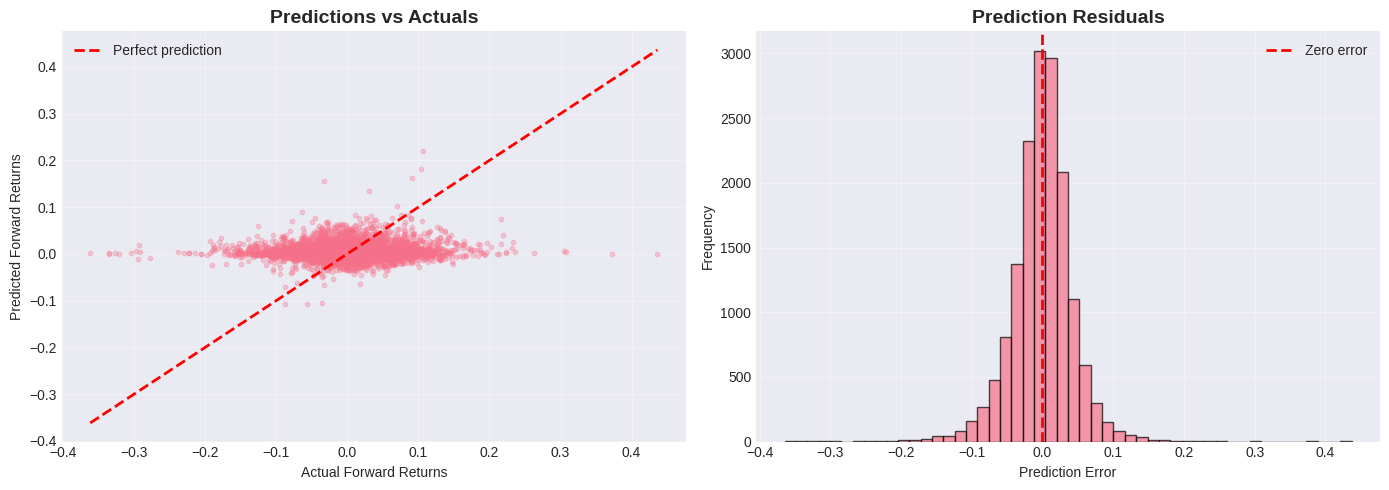

In [22]:
# Visualize predictions vs actuals
predictions = trainer.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, predictions, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Forward Returns')
axes[0].set_ylabel('Predicted Forward Returns')
axes[0].set_title('Predictions vs Actuals', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - predictions
axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Residuals', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save model
import os
model_path = 'data/models/latest_model.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
trainer.save_model(model_path)
print(f"✓ Model saved to {model_path}")

---
## Step 4: Portfolio Construction & Backtesting

Use ML scores to construct portfolio and backtest with realistic costs.

In [ ]:
from src.portfolio.construct import construct_portfolio
from src.backtest.bt_engine import VectorizedBacktester

# Generate scores for test period
X_test_full, _ = dataset.prepare(test_df, auto_select_features=False)
scores = trainer.predict(X_test_full)

# Filter test_df to match X_test_full (remove rows with missing labels)
test_df_clean = test_df[test_df[label_col].notna()].copy()
scored_df = test_df_clean[['date', 'symbol']].copy()
scored_df['ml_score'] = scores

print(f"✓ Generated ML scores for {len(scored_df):,} observations")
print(f"\nScore statistics:")
print(scored_df['ml_score'].describe())

In [ ]:
# Get price panel (always use real close prices!)
price_panel = df[['date', 'symbol', 'close']].copy()

print(f"Price panel: {len(price_panel):,} rows")
print(f"Date range: {price_panel['date'].min()} to {price_panel['date'].max()}")

In [ ]:
# Construct portfolio weights over time
print("Constructing portfolio weights...")
print(f"Using optimizer: {config['portfolio']['optimizer']}")
print(f"Top K positions: {config['portfolio']['top_k']}\n")

weights_history = []
unique_dates = sorted(scored_df['date'].unique())

# Limit to first 50 dates for demo (faster execution)
MAX_DATES = 50
rebalance_dates = unique_dates[:min(MAX_DATES, len(unique_dates))]

print(f"Constructing portfolio for {len(rebalance_dates)} rebalance dates...")

for i, date in enumerate(rebalance_dates):
    if i % 10 == 0:
        print(f"  Processing date {i+1}/{len(rebalance_dates)}: {date}")
    
    day_scores = scored_df[scored_df['date'] == date]
    weights = construct_portfolio(day_scores, price_panel, config)
    
    for symbol, weight in weights.items():
        weights_history.append({
            'date': date,
            'symbol': symbol,
            'weight': weight
        })

weights_df = pd.DataFrame(weights_history)
print(f"\n✓ Portfolio weights constructed")
print(f"  Total weight records: {len(weights_df):,}")
print(f"  Average positions per rebalance: {len(weights_df) / len(rebalance_dates):.1f}")

In [ ]:
# Examine portfolio weights
print("Sample portfolio weights:")
print(weights_df.head(20))

# Weight statistics
print(f"\nWeight statistics:")
print(weights_df['weight'].describe())

# Check constraints
weights_sum = weights_df.groupby('date')['weight'].sum()
print(f"\nPortfolio weight sum per date:")
print(f"  Mean: {weights_sum.mean():.4f}")
print(f"  Min:  {weights_sum.min():.4f}")
print(f"  Max:  {weights_sum.max():.4f}")
print(f"\n✓ Weights sum to ~1.0 (constraint satisfied)")

In [ ]:
# Run backtest
print("Running backtest...")
print(f"Cost assumptions:")
print(f"  Commission: {config['portfolio']['costs_bps']} bps")
print(f"  Slippage:   {config['portfolio']['slippage_bps']} bps\n")

backtester = VectorizedBacktester(config)
results = backtester.run(weights_df, price_panel)

print("\n" + "=" * 50)
print("BACKTEST RESULTS")
print("=" * 50)
print(f"\nTotal Return:        {results['metrics']['total_return']:.2%}")
print(f"Annualized Return:   {results['metrics'].get('annual_return', 0):.2%}")
print(f"Sharpe Ratio:        {results['metrics']['sharpe_ratio']:.2f}")
print(f"Max Drawdown:        {results['metrics']['max_drawdown']:.2%}")
print(f"Volatility:          {results['metrics'].get('volatility', 0):.2%}")
print(f"Avg Turnover:        {results['metrics'].get('avg_turnover', 0):.2%}")
print("=" * 50)

In [ ]:
# Visualize equity curve
equity_curve = results['equity_curve']

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
axes[0].plot(equity_curve['date'], equity_curve['equity'], linewidth=2, label='Portfolio Equity')
axes[0].set_title('Portfolio Equity Curve', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Equity ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drawdown
running_max = equity_curve['equity'].expanding().max()
drawdown = (equity_curve['equity'] - running_max) / running_max * 100

axes[1].fill_between(equity_curve['date'], drawdown, 0, alpha=0.5, color='red', label='Drawdown')
axes[1].set_title('Drawdown', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save backtest results
import os
os.makedirs('data/reports', exist_ok=True)
equity_curve.to_csv('data/reports/equity_curve.csv', index=False)
print("✓ Backtest results saved to data/reports/equity_curve.csv")

---
## Step 5: Populate Dashboard

Save results to database so the dashboard displays them.

In [ ]:
from src.database.models import init_database, PortfolioSnapshot
from datetime import datetime

# Initialize database
engine, SessionLocal = init_database()
db = SessionLocal()

print("✓ Database connection established")

In [ ]:
# Populate portfolio snapshots for dashboard
print("Populating dashboard data...")

snapshots_to_add = []
for _, row in equity_curve.iterrows():
    snapshot = PortfolioSnapshot(
        date=row['date'],
        total_equity=row['equity'],
        cash=0,  # Simplified - fully invested
        positions_value=row['equity'],
        daily_return=0,  # Can calculate if needed
        daily_pnl=0
    )
    snapshots_to_add.append(snapshot)

# Bulk insert
db.bulk_save_objects(snapshots_to_add)
db.commit()

print(f"✓ Added {len(snapshots_to_add)} portfolio snapshots to database")
db.close()

---
## ✅ Pipeline Complete!

### What You Accomplished:
1. ✓ Fetched OHLCV data for stocks
2. ✓ Generated technical features and labels
3. ✓ Trained ML model with evaluation metrics
4. ✓ Constructed portfolio and ran backtest
5. ✓ Populated dashboard database

### Next Steps:

**1. View Results in Dashboard:**
   - Go to http://localhost:8501 in your browser
   - Refresh the page to see your data
   - Navigate through Portfolio Overview, Signals, etc.

**2. Experiment & Iterate:**
   - Adjust `NUM_STOCKS` in Step 1 to test with more stocks
   - Modify parameters in `config/config.yaml`
   - Try different optimizers: `pypfopt`, `inverse_vol`, `equal_weight`
   - Change `top_k` for number of positions

**3. Production Automation:**
   - Once satisfied, use `python run_pipeline.py` for automated runs
   - Set up daily cron jobs for live operations
   - Use `src/live/` modules for real-time trading

**4. Further Analysis:**
   - View MLflow UI: `mlflow ui --port 5000`
   - Compare different model runs
   - Analyze feature importance

---

### Development → Production Checklist
- [ ] Test with larger universe (100+ stocks)
- [ ] Validate PIT alignment for fundamentals
- [ ] Optimize hyperparameters with Optuna
- [ ] Paper trade with `dry_run=True`
- [ ] Set up monitoring and alerts
- [ ] Document your strategy parameters
- [ ] Consider premium data providers

**Great job! Your ML trading system is now operational.** 🎉